In [1]:
# System 
import os
import sys

# Data and image processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import cv2
from PIL import Image
import albumentations as A
from tqdm import tqdm

# Pytorch libs
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset ,DataLoader
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
from torch import from_numpy



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = "drive/MyDrive/CitySc/"
train_directory= root + "cityscapes_data/train/"
val_directory = root + "cityscapes_data/val/"
train_img_names = os.listdir(train_directory)
val_img_names = os.listdir(val_directory)

**Hint:** Seprate the image into left and right  
org_img = cv2.imread(os.path.join(train_directory, img))  
imgg = org_img[:, 0:256,:]  
msk = org_img[:, 256:,:]  

In [6]:
class UNetTunable(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
        conv_mode='standard'
    ):
        super(UNetTunable, self).__init__()
        assert conv_mode in ('standard', 'dilated')
        assert up_mode in ('upconv', 'upsample', 'dilated')
        
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm,conv_mode)
            ).to(device)
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm,conv_mode)
            ).to(device)
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm,conv_mode):
        super(UNetConvBlock, self).__init__()
        
        if conv_mode == 'standard':
            block = []
            block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            self.block = nn.Sequential(*block)
            
        elif conv_mode == 'dilated':
            block = []
            block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding), dilation = 1 ))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding), dilation = 1 ))
            block.append(nn.ReLU())
            if batch_norm:
                block.append(nn.BatchNorm2d(out_size))
            self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, conv_mode):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )
        elif up_mode == 'dilated':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm, conv_mode)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out
        
class Dataset(Dataset):
    def __init__(self, images_list, size, mean = None, std = None):
        self.images_list = images_list
        self.size = size
        
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std
        
    def __len__(self):
        return len(os.listdir(self.images_list))

    def __getitem__(self, index):
        img = os.listdir(self.images_list)[index]
        pth = os.path.join(self.images_list, img)

        
          
        pil_image = Image.open(pth).convert('RGB')
        org_img = np.array(pil_image)
        
        np_image = org_img[:, 0:256,:]
        np_target = org_img[:, 256:,:] 
        
        test = (np_target.reshape(-1,3))      
        pred = encoder.predict(test)
        seg_msk = pred.reshape(256,256)
        
        
        
        trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])
            
        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img, img_tensor, seg_msk


kmeans_data = []
for img in train_img_names[0:50]:
    org_img = cv2.imread(os.path.join(train_directory, img))
    imgg = org_img[:, 0:256,:]
    msk = org_img[:, 256:,:]
    
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)

from sklearn.cluster import KMeans
encoder = KMeans(n_clusters=8)
encoder.fit(kmeans_data)


In [50]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label


def mean_iou(results, gt_seg_maps, num_classes, ignore_index):
    num_imgs = len(results)
    assert len(gt_seg_maps) == num_imgs
    total_area_intersect = np.zeros((num_classes, ), dtype=np.float)
    total_area_union = np.zeros((num_classes, ), dtype=np.float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=np.float)
    total_area_label = np.zeros((num_classes, ), dtype=np.float)
    for i in range(num_imgs):
        area_intersect, area_union, area_pred_label, area_label = \
            intersect_and_union(results[i], gt_seg_maps[i], num_classes,
                                ignore_index=ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union

    return all_acc, acc, iou



In [7]:
test_data_obj = Dataset(val_directory, 256, mean = None, std=None)
test_dataloader = DataLoader(test_data_obj, batch_size=1, shuffle=True)

In [ ]:
model = torch.load(root + '/myCtModel/epoch36.pkl')  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_scores = []
save_dir = root + '/val_pre/'
for batch in test_dataloader:
    img_id, imagee, msok = batch
    mskie = transforms.Resize(256)
    mskl = mskie(msok).long()
    
    model.to(device)
    imagee = imagee.to(device=device)
    p1 = model(imagee)
    p1 = torch.Tensor.cpu(p1)
    score_map = np.array(p1[0].squeeze(dim=0).permute(1,2,0))
    pre = np.argmax(score_map, axis=2)
    gt = np.squeeze(np.array(msok).astype(int))
    _, _, iou = mean_iou(pre, gt, 8, [])
    test_scores.append(iou)
    cv2.imwrite(save_dir + img_id[0][:-3] + 'png', pre)
    np.save(save_dir + img_id[0][:-3], score_map)

In [85]:
tmp = np.array(test_scores)
tmp = tmp[~np.isnan(tmp)]
tmp = tmp[tmp>5e-2]
print(np.mean(tmp))

0.57852701068503


The mIOU for only DCNN is 57.8

# Visualization

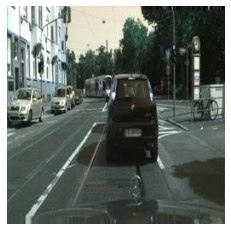

In [36]:
img_id = "9"
val_dir = "/cityscapes_data/val/"
orgs = cv2.imread(root+val_dir+img_id+".jpg")
img = orgs[:, 0:256,:]
msk = orgs[:, 256:,:]
plt.axis('off')
plt.imshow(img)

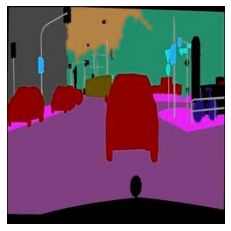

In [37]:
plt.axis('off')
plt.imshow(msk)

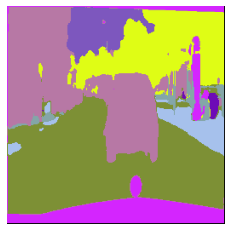

In [42]:
val_pre_dir = "/val_pre/"
pre = cv2.imread(root+val_pre_dir+img_id+".png")
color = np.random.choice(256, 3*8)
color = color.reshape([3, 8])
res = np.zeros([256, 256, 3])
for m in range(0, 255):
    for n in range(0, 255):
            res[m, n, :] = color[:, int(pre[m, n, 0])]
plt.axis('off')
plt.imshow(res.astype(int))

# CRF

In [7]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-l4uhmlqx
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-l4uhmlqx
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2781978 sha256=1a7774f0186d89d850919162b95c18058fb3f7b21107299baa42d0b9b73f7636
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ejb0tn8/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


## Visualize

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F

import itertools
from PIL import Image

import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

class DenseCRF(object):
    def __init__(self, iter_max, pos_w, pos_xy_std, bi_w, bi_xy_std, bi_rgb_std):
        self.iter_max = iter_max
        self.pos_w = pos_w
        self.pos_xy_std = pos_xy_std
        self.bi_w = bi_w
        self.bi_xy_std = bi_xy_std
        self.bi_rgb_std = bi_rgb_std

    def __call__(self, image, probmap):
        C, H, W = probmap.shape

        U = utils.unary_from_softmax(probmap)
        U = np.ascontiguousarray(U)

        image = np.ascontiguousarray(image)

        d = dcrf.DenseCRF2D(W, H, C)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=self.pos_xy_std, compat=self.pos_w)
        d.addPairwiseBilateral(
            sxy=self.bi_xy_std, srgb=self.bi_rgb_std, rgbim=image, compat=self.bi_w
        )

        Q = d.inference(self.iter_max)
        Q = np.array(Q).reshape((C, H, W))

        return Q

crf_city = DenseCRF(
    iter_max=10,    
    pos_xy_std=3,   
    pos_w=3,        
    bi_xy_std=140,  
    bi_rgb_std=5,
    bi_w=5,)

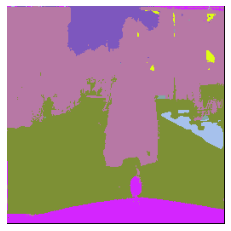

In [43]:
probmap = np.load(root + "/val_pre/" + img_id +"..npy")

probmap = probmap.transpose((2,0,1))
raw_image = img.astype(np.uint8)
prob = crf_city(raw_image, probmap)
crf_pre = np.argmax(prob, axis=0).astype(np.uint8)
res = np.zeros([256, 256, 3])
for m in range(0, 255):
    for n in range(0, 255):
            res[m, n, :] = color[:, int(crf_pre[m, n])]
plt.axis('off')
plt.imshow(res.astype(int))

In [52]:
test_scores=[]
for img_id in val_img_names:
  orgs = cv2.imread(root+val_dir+img_id)
  img = orgs[:, 0:256,:]
  msk = orgs[:, 256:,0]
  probmap = np.load(root + 'val_pre/' + img_id[:-3] +".npy")

  probmap = probmap.transpose((2,0,1))
  raw_image = img.astype(np.uint8)
  prob = crf_city(raw_image, probmap)
  crf_pre = np.argmax(prob, axis=0).astype(np.uint8)
  _, _, iou = mean_iou(crf_pre, msk, 8, [])
  test_scores.append(iou)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for 

In [54]:
tmp = np.array(test_scores)
tmp = tmp[~np.isnan(tmp)]
tmp = tmp[tmp>1e-1]
print(np.mean(tmp))

0.14891108294799496
